In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.models.gaussian_process import *
from encoding_information.plot_utils import *

from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2023-10-27 10:50:26.242524: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-27 10:50:26.886062: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cublas/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_cupti/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvcc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvrtc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_runtime/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/pyth

Opening BSCCM
Opened BSCCM


In [2]:
# load images, extract patches, and compute cov mats
edge_crop = 32
num_images = 10000
num_patches = 10000
channel = 'LED119'
eigenvalue_floor = 1e-3

num_test_images = 1000

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_images, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_images = all_images[num_images:]


In [3]:
patch_sizes = [1, 2, 3, 5, 10, 20, 35, 50]
num_samples = 8
sample_size = 80


patch_sizes = [1, 5, 10]
num_samples = 8
sample_size = 40


# load train and test patches corresponding to the biggest patch size
patches = extract_patches(images, patch_sizes[-1], num_patches=num_patches, seed=0, verbose=True)
test_patches = extract_patches(test_images, patch_sizes[-1], num_patches=num_test_images, seed=0, verbose=True)


test_set_NLL_gp = {}
test_set_NLL_pixel_cnn = {}
mi_estimates_gp = {}
mi_estimates_pixel_cnn = {}
samples = {}
for patch_size in tqdm(patch_sizes):
    # take a random sub crop from the patchs
    subpatches = extract_patches(patches, patch_size, num_patches=num_patches, seed=0, verbose=False)
    test_subpatches = extract_patches(test_patches, patch_size, num_patches=num_test_images, seed=0, verbose=False)

    mi_estimates_gp[patch_size], stationary_gp = estimate_mutual_information(
        subpatches, eigenvalue_floor=eigenvalue_floor, use_iterative_optimization=True, return_entropy_model=True,
        verbose=True)
    test_set_NLL_gp[patch_size] = stationary_gp.compute_negative_log_likelihood(test_subpatches)

    mi_estimates_pixel_cnn[patch_size], pixel_cnn = estimate_mutual_information(
        subpatches, entropy_model='pixelcnn', return_entropy_model=True, verbose=True)
    test_set_NLL_pixel_cnn[patch_size] = pixel_cnn.compute_negative_log_likelihood(test_subpatches)

    samples[patch_size] = {}
    print('generating samples GP')
    samples[patch_size]['GP'] = stationary_gp.generate_samples(num_samples=num_samples, sample_shape=sample_size, seed=None)
    print('generating samples PixelCNN')
    samples[patch_size]['PixelCNN'] = pixel_cnn.generate_samples(num_samples=num_samples, sample_shape=sample_size, seed=None)


 34%|███▍      | 3405/10000 [00:28<00:57, 114.35it/s]

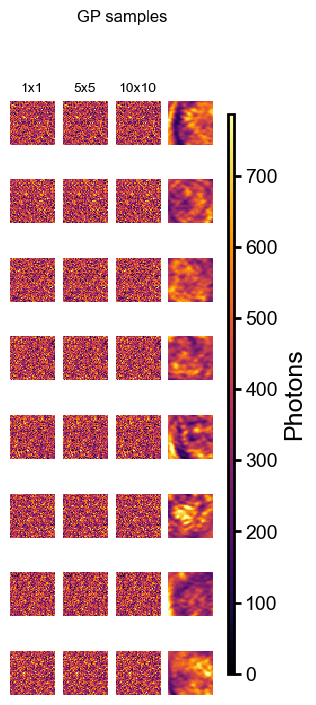

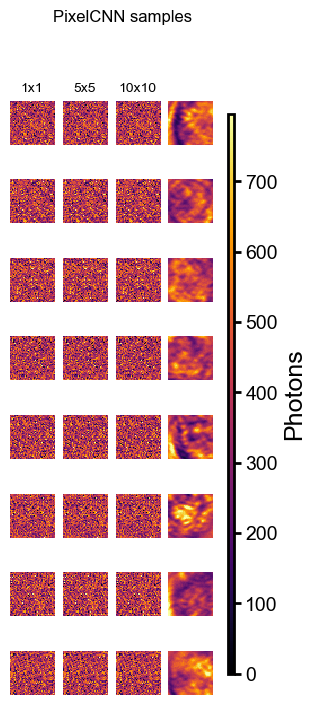

In [18]:
for model_name in ['GP', 'PixelCNN']:
    fig, axs = plt.subplots(num_samples, len(patch_sizes) + 1, figsize=( len(patch_sizes), num_samples ), sharex=True, sharey=True)
    vmin, vmax = None, None
    for j, patch_size in enumerate(patch_sizes):
        model_samples_for_patch_size = samples[patch_sizes[0]][model_name]
        if vmin is None:
            vmin, vmax = np.percentile(model_samples_for_patch_size, .1), np.percentile(model_samples_for_patch_size, 99.9)
        for i in range(num_samples):
            im = axs[i, j].imshow(model_samples_for_patch_size[i], cmap='inferno', vmin=vmin, vmax=vmax, interpolation='none')
            axs[i, j].axis('off')

    # show ground truth patch
    display_patches = extract_patches(images, sample_size, num_patches=num_samples, seed=7)
    for i in range(num_samples):
        axs[i, -1].imshow(display_patches[i], cmap='inferno', vmin=vmin, vmax=vmax, interpolation='none')
        axs[i, -1].axis('off')

    # add colorbar
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    cbar_ax.set_ylabel('Photons')

    # add a label to each col
    for j, patch_size in enumerate(patch_sizes):
        axs[0, j].set_title(f'{patch_size}x{patch_size}', fontsize=10)
    fig.suptitle(f'{model_name} samples', fontsize=12)

/tmp/ipykernel_954/1978279045.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=[''] + [f'{ps}x{ps}' for ps in np.arange(10, 51, 10)], xticks=np.arange(0, 51, 10))


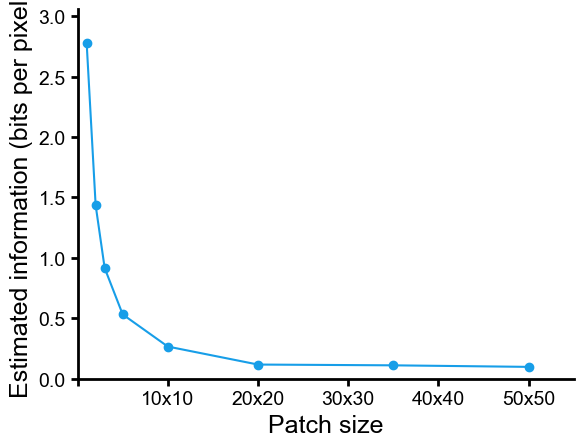

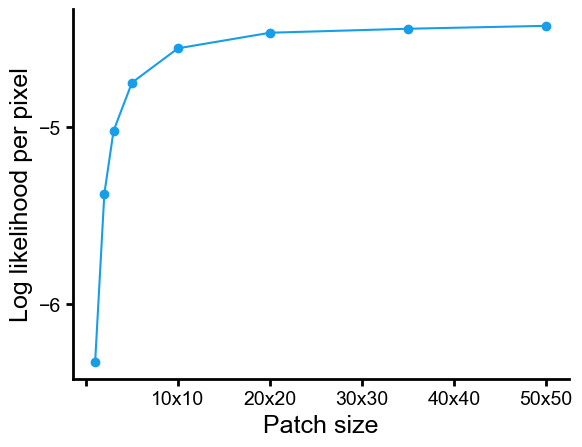

: 

In [ ]:
from matplotlib.ticker import MaxNLocator

# Mutual information vs patch size
fig, ax = plt.subplots()
ax.plot(patch_sizes, [mi_estimates_gp[ps] for ps in patch_sizes], 'o-', label='GP')
ax.plot(patch_sizes, [mi_estimates_pixel_cnn[ps] for ps in patch_sizes], 'o-', label='PixelCNN')
clear_spines(ax)
ax.set(xlabel='Patch size', ylabel='Estimated information (bits per pixel)', ylim=[0, 1.1 * 
                        max(max(mi_estimates_gp.values()), max(mi_estimates_pixel_cnn.values()))  ],
        xlim=[0, 1.1 * max(patch_sizes)], xticks=np.arange(0, 51, 10))
ax.set(xticklabels=[''] +[f'{ps}x{ps}' for ps in np.arange(10, 51, 10)])
ax.legend()

fig, ax = plt.subplots()
nll_per_pixel_gp = [test_set_NLL_gp[ps] for ps in patch_sizes]
nll_per_pixel_pixel_cnn = [test_set_NLL_pixel_cnn[ps] for ps in patch_sizes]

ax.plot(patch_sizes, nll_per_pixel_gp, 'o-', label='GP')
ax.plot(patch_sizes, nll_per_pixel_pixel_cnn, 'o-', label='PixelCNN')

clear_spines(ax)
ax.set(xlabel='Patch size', ylabel='Negative Log likelihood per pixel')
ax.set(xticklabels=[''] + [f'{ps}x{ps}' for ps in np.arange(10, 51, 10)], xticks=np.arange(0, 51, 10))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
